<a href="https://colab.research.google.com/github/asj07/DB/blob/main/finalFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier



In [131]:
from google.colab import files

uploaded = files.upload()   # choose your TradingView export (e.g. in.csv)
file_name = list(uploaded.keys())[0]
print("Using file:", file_name)


Saving in (1).csv to in (1).csv
Using file: in (1).csv


In [132]:
df_raw = pd.read_csv(file_name)
print(df_raw.head())
print(df_raw.shape)


  tableContentSpan-nT3JTIUn  tableContentSpan-nT3JTIUn 2  \
0    Fri 28 Nov '25   15:15                       167.87   
1    Fri 28 Nov '25   15:00                       167.80   
2    Fri 28 Nov '25   14:45                       167.98   
3    Fri 28 Nov '25   14:30                       168.06   
4    Fri 28 Nov '25   14:15                       168.10   

   tableContentSpan-nT3JTIUn 3  tableContentSpan-nT3JTIUn 4  \
0                       168.17                       167.81   
1                       168.09                       167.79   
2                       167.98                       167.71   
3                       168.15                       167.90   
4                       168.13                       167.92   

   tableContentSpan-nT3JTIUn 5 tableContentSpan-nT3JTIUn 6  \
0                       168.14              +0.27 (+0.16%)   
1                       167.87              +0.07 (+0.04%)   
2                       167.80              −0.18 (−0.11%)   
3           

In [133]:
df = df_raw.copy()

# Rename columns based on observation from df_raw.head()
df.columns = ["Datetime", "Open", "High", "Low", "Close", "Change", "Volume"]
print("After renaming columns:")
print(df.head())
print(df.dtypes)
print("NaN counts:")
print(df.isnull().sum())
print("-" * 30)

# Convert 'Datetime' to actual datetime objects, explicitly providing the format
df["Datetime"] = pd.to_datetime(df["Datetime"], format='%a %d %b \'%y %H:%M', errors="coerce")
print("After Datetime conversion:")
print(df.head())
print(df.dtypes)
print("NaN counts:")
print(df.isnull().sum())
print("-" * 30)

# Determine which columns to select for 'final' after potential 'Datetime' removal
cols_for_final = ["Datetime","Open","High","Low","Close","Volume"]

# If 'Datetime' is entirely NaT, remove it from the dataframe and from the list of cols_for_final
if df["Datetime"].isnull().all():
    print("Warning: 'Datetime' column is entirely missing or unparseable after conversion. It will not be used.")
    df = df.drop(columns=["Datetime"])
    cols_for_final.remove("Datetime")


# Convert price columns to numeric, stripping non-numeric characters if any
for col in ["Close", "High", "Low", "Open"]:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
print("After price column conversion:")
print(df.head())
print(df.dtypes)
print("NaN counts:")
print(df.isnull().sum())
print("-" * 30)

# Clean and convert 'Volume'
def clean_volume(volume_str):
    if isinstance(volume_str, str):
        # Explicitly replace the narrow no-break space (\u202f) and then other spaces
        volume_str = volume_str.replace('\u202f', '').replace(' ', '').strip()
        if 'M' in volume_str:
            return pd.to_numeric(volume_str.replace('M', ''), errors='coerce') * 1_000_000
        elif 'K' in volume_str:
            return pd.to_numeric(volume_str.replace('K', ''), errors='coerce') * 1_000
        else:
            return pd.to_numeric(volume_str, errors='coerce')
    return volume_str # Already numeric or NaN

df["Volume"] = df["Volume"].apply(clean_volume)
print("After Volume conversion:")
print(df.head())
print(df.dtypes)
print("NaN counts:")
print(df.isnull().sum())
print("-" * 30)

# Select the required columns and drop any rows with NaN values created by 'coerce' errors
final = df[cols_for_final].dropna().reset_index(drop=True)

# Sort by Datetime only if it exists in the final DataFrame
if "Datetime" in final.columns:
    final = final.sort_values("Datetime").reset_index(drop=True)

print("Final DataFrame head:")
print(final.head())
print("Final DataFrame shape:")
print(final.shape)

After renaming columns:
                 Datetime    Open    High     Low   Close          Change  \
0  Fri 28 Nov '25   15:15  167.87  168.17  167.81  168.14  +0.27 (+0.16%)   
1  Fri 28 Nov '25   15:00  167.80  168.09  167.79  167.87  +0.07 (+0.04%)   
2  Fri 28 Nov '25   14:45  167.98  167.98  167.71  167.80  −0.18 (−0.11%)   
3  Fri 28 Nov '25   14:30  168.06  168.15  167.90  167.98  −0.09 (−0.05%)   
4  Fri 28 Nov '25   14:15  168.10  168.13  167.92  168.07  −0.02 (−0.01%)   

     Volume  
0    1.22 M  
1  725.27 K  
2  322.02 K  
3  160.95 K  
4   136.5 K  
Datetime     object
Open        float64
High        float64
Low         float64
Close       float64
Change       object
Volume       object
dtype: object
NaN counts:
Datetime    0
Open        0
High        0
Low         0
Close       0
Change      0
Volume      0
dtype: int64
------------------------------
After Datetime conversion:
             Datetime    Open    High     Low   Close          Change  \
0 2025-11-28 15:15:00

In [134]:
df_feat = final.copy()

# 1) Log returns
df_feat["return"] = np.log(df_feat["Close"] / df_feat["Close"].shift(1))

# 2) Historical volatility (20-period)
lookback_hv = 20
df_feat["hv_20"] = df_feat["return"].rolling(lookback_hv).std()

# 3) Volatility regime (0 low, 1 mid, 2 high)
low_q = df_feat["hv_20"].quantile(0.33)
high_q = df_feat["hv_20"].quantile(0.66)

def vol_regime(x):
    if pd.isna(x): return np.nan
    if x < low_q: return 0
    elif x < high_q: return 1
    else: return 2

df_feat["vol_regime"] = df_feat["hv_20"].apply(vol_regime)

# 4) Trend strength & slope (10-bar)
trend_len = 10
df_feat["trend_strength"] = df_feat["Close"] - df_feat["Close"].shift(trend_len)
df_feat["trend_slope"] = df_feat["trend_strength"] / trend_len

# 5) Range
df_feat["range"] = df_feat["High"] - df_feat["Low"]
range_ma = df_feat["range"].rolling(lookback_hv).mean()

# 6) Compression / expansion flags
df_feat["compression"] = ((df_feat["hv_20"] < low_q) & (df_feat["range"] < range_ma)).astype(int)
df_feat["expansion"] = ((df_feat["hv_20"] > high_q) & (df_feat["range"] > range_ma)).astype(int)

# 7) Settlement proxy & gap
df_feat["settlement"] = (df_feat["High"] + df_feat["Low"] + df_feat["Close"]) / 3.0
df_feat["settlement_gap"] = df_feat["Close"] - df_feat["settlement"]

# 8) Target: next-candle direction
df_feat["future_close"] = df_feat["Close"].shift(-1)
df_feat["target"] = (df_feat["future_close"] > df_feat["Close"]).astype(int)

df_feat_clean = df_feat.dropna().reset_index(drop=True)
print(df_feat_clean.head(), df_feat_clean.shape)


             Datetime    Open    High     Low   Close     Volume    return  \
0 2024-11-29 13:30:00  144.93  145.49  144.92  145.15  1150000.0  0.001379   
1 2024-11-29 13:45:00  145.15  145.29  145.01  145.21   611210.0  0.000413   
2 2024-11-29 14:00:00  145.19  145.31  144.82  144.82   693200.0 -0.002689   
3 2024-11-29 14:15:00  144.81  145.18  144.81  145.17   609510.0  0.002414   
4 2024-11-29 14:30:00  145.17  145.20  144.87  144.98  1190000.0 -0.001310   

      hv_20  vol_regime  trend_strength  trend_slope  range  compression  \
0  0.002233         1.0            0.32        0.032   0.57            0   
1  0.002014         0.0           -0.04       -0.004   0.28            1   
2  0.002093         1.0            0.04        0.004   0.49            0   
3  0.002099         1.0            0.65        0.065   0.37            0   
4  0.002026         0.0            0.16        0.016   0.33            1   

   expansion  settlement  settlement_gap  future_close  target  
0        

In [135]:
def add_binocular_features(df,
                           bfr=0.02,
                           lookback=21,
                           annual=252,
                           daysto_expire=1,
                           signal_length=21):
    # Handle empty DataFrame immediately
    if df.empty:
        # Return an empty DataFrame with expected binocular feature columns
        # This ensures downstream merges or operations don't break due to missing columns
        empty_cols = ["Datetime", "bin_settlement", "bin_hv", "bin_sd_1_up", "bin_sd_1_dn",
                      "bin_dist_to_settlement", "pvt", "pvt_signal", "rsi_25", "rsi_55",
                      "atr_10", "longStop_raw", "shortStop_raw", "longStop", "shortStop",
                      "bin_dir", "bin_buy", "bin_sell", "bin_bs", "bin_pos"]
        return pd.DataFrame(columns=empty_cols)

    df = df.copy().sort_values("Datetime").reset_index(drop=True)

    # === Daily settlement & HV ===
    dfd = df.set_index("Datetime")
    daily_close = dfd["Close"].resample("1D").last().dropna()
    # Handle case where daily_close might become empty after resample/dropna
    if daily_close.empty: # added check for empty daily_close
        return pd.DataFrame(columns=df.columns.tolist() + ["bin_settlement","bin_hv","bin_sd_1_up","bin_sd_1_dn","bin_dist_to_settlement",
                                                           "pvt","pvt_signal","rsi_25","rsi_55","atr_10","longStop_raw","shortStop_raw",
                                                           "longStop","shortStop","bin_dir","bin_buy","bin_sell","bin_bs","bin_pos"])

    log_ret_d = np.log(daily_close / daily_close.shift(1))
    hv_daily = log_ret_d.rolling(lookback).std() * np.sqrt(annual)

    hv_daily = hv_daily.reindex(dfd.index, method="ffill")
    settlement = daily_close.shift(1).reindex(dfd.index, method="ffill")
    stdhv = settlement * hv_daily * np.sqrt(daysto_expire / annual)

    df["bin_settlement"] = settlement.values
    df["bin_hv"] = hv_daily.values
    df["bin_sd_1_up"] = df["bin_settlement"] + stdhv.values
    df["bin_sd_1_dn"] = df["bin_settlement"] - stdhv.values
    df["bin_dist_to_settlement"] = df["Close"] - df["bin_settlement"]

    # === Price Volume Trend & smoothed signal ===
    df["pvt"] = (((df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)) * df["Volume"]).cumsum().fillna(0)
    df["pvt_signal"] = df["pvt"].ewm(span=signal_length, adjust=False).mean()

    # === RSI(25) & RSI(55) ===
    def rsi(series, length):
        delta = series.diff()
        gain = delta.clip(lower=0).rolling(length).mean()
        loss = -delta.clip(upper=0).rolling(length).mean()
        rs = gain / loss
        # Handle division by zero for rs
        rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0) # Replace inf with 0 or a small number
        return 100 - 100 / (1 + rs)

    df["rsi_25"] = rsi(df["Close"], 25)
    df["rsi_55"] = rsi(df["Close"], 55)

    # === ATR-based trailing stops (10, 2.2) ===
    length = 10
    mult = 2.2

    high_low = df["High"] - df["Low"]
    high_close_prev = (df["High"] - df["Close"].shift(1)).abs()
    low_close_prev = (df["Low"] - df["Close"].shift(1)).abs()
    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    atr = tr.rolling(length).mean() * mult

    df["atr_10"] = atr
    roll_high = df["Close"].rolling(length).max()
    roll_low  = df["Close"].rolling(length).min()

    df["longStop_raw"]  = roll_high - atr
    df["shortStop_raw"] = roll_low  + atr

    df["longStop"] = df["longStop_raw"].copy()
    df["shortStop"] = df["shortStop_raw"].copy()

    for i in range(1, len(df)):
        prev_long = df.at[i-1, "longStop"]
        ls = df.at[i, "longStop_raw"]
        df.at[i, "longStop"] = max(ls, prev_long) if df.at[i-1,"Close"] > prev_long else ls

        prev_short = df.at[i-1, "shortStop"]
        ss = df.at[i, "shortStop_raw"]
        df.at[i, "shortStop"] = min(ss, prev_short) if df.at[i-1,"Close"] < prev_short else ss

    # === Direction & BUY/SELL ===
    dir_vals = [1]
    for i in range(1, len(df)):
        if df["Close"].iloc[i] > df["shortStop"].iloc[i-1]:
            d = 1
        elif df["Close"].iloc[i] < df["longStop"].iloc[i-1]:
            d = -1
        else:
            d = dir_vals[-1]
        dir_vals.append(d)

    df["bin_dir"] = dir_vals

    # Ensure all series being compared have the same index before comparison
    pvt_aligned, pvt_signal_aligned = df["pvt"].align(df["pvt_signal"], join='inner')
    rsi_25_aligned, rsi_55_aligned = df["rsi_25"].align(df["rsi_55"], join='inner')
    bin_dir_aligned = df["bin_dir"].reindex(pvt_aligned.index) # Align bin_dir with the common index

    df["bin_buy"] = ((bin_dir_aligned == 1) &
                     (pvt_aligned > pvt_signal_aligned) &
                     (rsi_25_aligned > rsi_55_aligned)).astype(int)

    df["bin_sell"] = ((bin_dir_aligned == -1) &
                      (pvt_aligned < pvt_signal_aligned) &
                      (rsi_25_aligned < rsi_55_aligned)).astype(int)

    # === Trade-panel state: bs (setup) & pos (in trade) ===
    bs_list, pos_list = [], []
    buy = sell = buy1 = sell1 = False
    HighVal = LowVal = np.nan
    bs = 0
    pos = 0

    # Iterate over the aligned index
    for idx in df.index:
        BUY = bool(df["bin_buy"].loc[idx])
        SELL = bool(df["bin_sell"].loc[idx])

        high = df["High"].loc[idx]
        low  = df["Low"].loc[idx]

        # Access previous values safely, handling the first element
        if idx > df.index[0]: # Check if not the very first element
            prev_idx = df.index[df.index.get_loc(idx) - 1]
            high_prev = df["High"].loc[prev_idx]
            low_prev  = df["Low"].loc[prev_idx]
            prev_bin_buy = df["bin_buy"].loc[prev_idx]
            prev_bin_sell = df["bin_sell"].loc[prev_idx]
            prev_close = df["Close"].loc[prev_idx]
            prev_longStop = df["longStop"].loc[prev_idx]
            prev_shortStop = df["shortStop"].loc[prev_idx]
        else:
            high_prev = high
            low_prev = low
            prev_bin_buy = False
            prev_bin_sell = False
            prev_close = df["Close"].loc[idx]
            prev_longStop = np.nan
            prev_shortStop = np.nan

        if BUY and not prev_bin_buy and not buy:
            bs = 1
            pos = 0
            buy, sell, sell1 = True, False, False
            HighVal = high * (1 + bfr/100)

        elif SELL and not prev_bin_sell and not sell:
            bs = -1
            pos = 0
            sell, buy, buy1 = True, False, False
            LowVal = low * (1 - bfr/100)

        if buy and (high > HighVal) and not buy1:
            pos = 1
            buy1, sell1 = True, False

        if sell and (low < LowVal) and not sell1:
            pos = -1
            sell1, buy1 = True, False

        bs_list.append(bs)
        pos_list.append(pos)

    df["bin_bs"]  = bs_list
    df["bin_pos"] = pos_list

    return df

In [136]:
bin_base = df_feat_clean[["Datetime","Open","High","Low","Close","Volume"]]
bin_df = add_binocular_features(bin_base)

df_with_bin = df_feat_clean.merge(
    bin_df[["Datetime",
            "bin_settlement","bin_hv",
            "bin_sd_1_up","bin_sd_1_dn",
            "bin_dist_to_settlement",
            "bin_buy","bin_sell",
            "bin_bs","bin_pos"]],
    on="Datetime",
    how="left"
)

df_with_bin = df_with_bin.dropna().reset_index(drop=True)
print(df_with_bin.head(), df_with_bin.shape)


             Datetime    Open    High     Low   Close     Volume    return  \
0 2025-01-01 09:15:00  138.06  138.45  137.52  137.70  1340000.0 -0.003263   
1 2025-01-01 09:30:00  137.70  137.72  137.21  137.35   744420.0 -0.002545   
2 2025-01-01 09:45:00  137.34  137.36  136.80  137.11  1000000.0 -0.001749   
3 2025-01-01 10:00:00  137.13  137.25  136.82  137.15   720210.0  0.000292   
4 2025-01-01 10:15:00  137.12  137.15  136.90  137.07   664410.0 -0.000583   

      hv_20  vol_regime  trend_strength  ...  target  bin_settlement  \
0  0.001639         0.0            0.05  ...       0          138.15   
1  0.001551         0.0           -0.43  ...       0          138.15   
2  0.001591         0.0           -1.00  ...       1          138.15   
3  0.001579         0.0           -1.13  ...       0          138.15   
4  0.001572         0.0           -1.37  ...       1          138.15   

     bin_hv  bin_sd_1_up  bin_sd_1_dn  bin_dist_to_settlement  bin_buy  \
0  0.166926   139.602696

In [137]:
df_opt = df_with_bin.copy()

df_opt["hv_10"] = df_opt["return"].rolling(10).std()
df_opt["hv_30"] = df_opt["return"].rolling(30).std()
df_opt["ret_5"] = df_opt["return"].rolling(5).sum()

df_opt = df_opt.dropna().reset_index(drop=True)
print(df_opt.head(), df_opt.shape)


             Datetime    Open    High     Low   Close    Volume    return  \
0 2025-01-02 10:15:00  136.70  137.20  136.60  137.06  807510.0  0.002484   
1 2025-01-02 10:30:00  137.06  137.07  136.85  136.93  526640.0 -0.000949   
2 2025-01-02 10:45:00  136.92  137.19  136.92  137.10  868630.0  0.001241   
3 2025-01-02 11:00:00  137.09  137.15  136.87  137.04  670110.0 -0.000438   
4 2025-01-02 11:15:00  137.04  137.17  136.83  136.99  637520.0 -0.000365   

      hv_20  vol_regime  trend_strength  ...  bin_sd_1_up  bin_sd_1_dn  \
0  0.000890         0.0            0.01  ...   138.288422   135.491578   
1  0.000901         0.0           -0.06  ...   138.288422   135.491578   
2  0.000944         0.0            0.13  ...   138.288422   135.491578   
3  0.000950         0.0            0.26  ...   138.288422   135.491578   
4  0.000954         0.0            0.22  ...   138.288422   135.491578   

   bin_dist_to_settlement  bin_buy  bin_sell  bin_bs  bin_pos     hv_10  \
0                

In [138]:
extended_features = [
    "hv_20","hv_10","hv_30",
    "vol_regime",
    "trend_strength","trend_slope",
    "range",
    "compression","expansion",
    "settlement_gap",
    "ret_5",
    # Binocular features:
    "bin_dist_to_settlement",
    "bin_buy","bin_sell",
    "bin_bs","bin_pos"
]

X = df_opt[extended_features]
y = df_opt["target"]

split_ratio = 0.8
split_index = int(len(df_opt) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(X_train.shape, X_test.shape)


(3708, 16) (928, 16)


In [139]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [140]:
# Logistic
log_clf = LogisticRegression(max_iter=3000)
log_clf.fit(X_train_scaled, y_train)
y_pred_log = log_clf.predict(X_test_scaled)
print("Logistic Accuracy:", accuracy_score(y_test, y_pred_log))

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("\nXGBoost Report:\n", classification_report(y_test, y_pred_xgb))


Logistic Accuracy: 0.540948275862069
RandomForest Accuracy: 0.5431034482758621
XGBoost Accuracy: 0.5183189655172413

XGBoost Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55       499
           1       0.48      0.48      0.48       429

    accuracy                           0.52       928
   macro avg       0.52      0.52      0.52       928
weighted avg       0.52      0.52      0.52       928



In [141]:
test_slice = df_opt.iloc[split_index:].copy()
test_slice["pred_xgb"] = y_pred_xgb

# Go long when prediction = 1, hold one bar
test_slice["strategy_ret"] = test_slice["return"] * test_slice["pred_xgb"]

num_trades = (test_slice["pred_xgb"] == 1).sum()
wins = (test_slice["strategy_ret"] > 0).sum()
win_rate = wins / num_trades * 100 if num_trades > 0 else 0
avg_ret = test_slice["strategy_ret"].mean() * 100

print("Trades:", num_trades)
print("Wins:", wins)
print(f"Win rate: {win_rate:.2f}%")
print(f"Avg return per trade: {avg_ret:.4f}%")


Trades: 430
Wins: 164
Win rate: 38.14%
Avg return per trade: -0.0129%


In [142]:
# From earlier:
# df_opt, X_train, X_test, y_train, y_test, extended_features
print(df_opt.shape)
print(X_train.shape, X_test.shape)


(4636, 30)
(3708, 16) (928, 16)


In [143]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [200, 300, 400, 500, 700],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
}

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [144]:
best_xgb = search.best_estimator_

y_pred_best = best_xgb.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print("Tuned XGBoost Accuracy:", acc_best)
print("\nReport:\n", classification_report(y_test, y_pred_best))


Tuned XGBoost Accuracy: 0.5323275862068966

Report:
               precision    recall  f1-score   support

           0       0.55      0.69      0.61       499
           1       0.49      0.35      0.41       429

    accuracy                           0.53       928
   macro avg       0.52      0.52      0.51       928
weighted avg       0.52      0.53      0.52       928



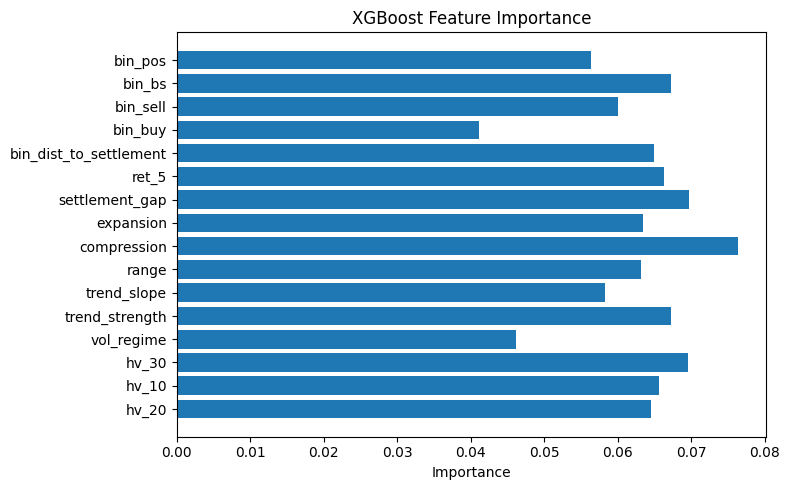

In [167]:
import matplotlib.pyplot as plt

importances = best_xgb.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(extended_features, importances)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [146]:
test_slice = df_opt.iloc[int(len(df_opt)*0.8):].copy()
test_slice["pred_best"] = y_pred_best

# Go long when prediction = 1, hold for 1 bar
test_slice["strategy_ret_best"] = test_slice["return"] * test_slice["pred_best"]

num_trades = (test_slice["pred_best"] == 1).sum()
wins = (test_slice["strategy_ret_best"] > 0).sum()
win_rate = wins / num_trades * 100 if num_trades > 0 else 0
avg_ret = test_slice["strategy_ret_best"].mean() * 100

print("Trades:", num_trades)
print("Wins:", wins)
print(f"Win rate (tuned XGB): {win_rate:.2f}%")
print(f"Avg return per trade: {avg_ret:.4f}%")


Trades: 303
Wins: 82
Win rate (tuned XGB): 27.06%
Avg return per trade: -0.0328%


In [147]:
# Predict on entire dataset (not just test)
df_opt["ml_signal"] = best_xgb.predict(df_opt[extended_features])


In [148]:
SL_pct  = 0.005   # 0.5% stop loss
TP_pct  = 0.010   # 1% take profit


In [149]:
import numpy as np

def run_backtest(df, signal_col="ml_signal", SL_pct=0.005, TP_pct=0.01):

    df = df.copy()
    df["Position"] = 0
    df["Trade_Return"] = 0.0
    df["Exit_Reason"] = ""

    in_trade = False
    entry_price = 0
    sl = 0
    tp = 0
    entry_index = None

    trades = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i-1]

        # ============================
        # NEW ENTRY (ML = BUY)
        # ============================
        if not in_trade and prev[signal_col] == 1:
            in_trade = True
            entry_price = row["Close"]
            sl = entry_price * (1 - SL_pct)
            tp = entry_price * (1 + TP_pct)
            entry_index = i
            continue

        # ============================
        # EXIT CONDITIONS
        # ============================
        if in_trade:
            price = row["Close"]

            # SL Hit
            if price <= sl:
                ret = (sl - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "SL"
                trades.append(ret)
                in_trade = False
                continue

            # TP Hit
            if price >= tp:
                ret = (tp - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "TP"
                trades.append(ret)
                in_trade = False
                continue

            # Reverse signal
            if prev[signal_col] == 1 and row[signal_col] == 0:
                ret = (price - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "EXIT_SIGNAL"
                trades.append(ret)
                in_trade = False
                continue

    return df, trades


In [150]:
bt_df, trades = run_backtest(df_opt, "ml_signal", SL_pct, TP_pct)

print("Number of Trades:", len(trades))


Number of Trades: 629


<Axes: title={'center': 'ML Strategy Equity Curve'}>

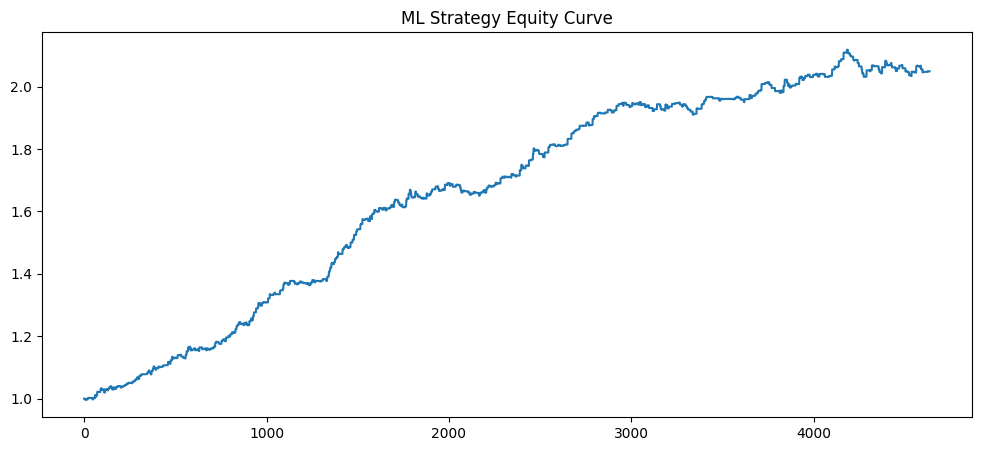

In [151]:
bt_df["Equity"] = (1 + bt_df["Trade_Return"]).cumprod()

bt_df["Equity"].plot(figsize=(12,5), title="ML Strategy Equity Curve")


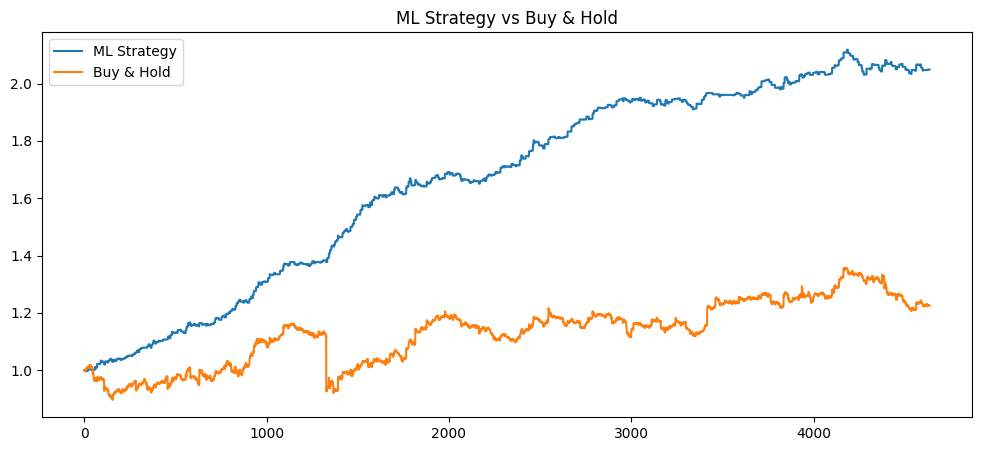

In [152]:
buy_hold = df_opt["Close"] / df_opt["Close"].iloc[0]

plt.figure(figsize=(12,5))
plt.plot(bt_df["Equity"], label="ML Strategy")
plt.plot(buy_hold, label="Buy & Hold")
plt.legend()
plt.title("ML Strategy vs Buy & Hold")
plt.show()


In [153]:
trade_log = bt_df[bt_df["Trade_Return"] != 0][["Datetime","Trade_Return","Exit_Reason"]]
trade_log.to_csv("Trade_Log.csv", index=False)
trade_log.head()


,Datetime,Trade_Return,Exit_Reason
6,2025-01-02 11:45:00,-0.003501,EXIT_SIGNAL
14,2025-01-02 13:45:00,0.001521,EXIT_SIGNAL
21,2025-01-03 09:15:00,0.004487,EXIT_SIGNAL
46,2025-01-06 09:15:00,-0.005000,SL
49,2025-01-06 10:00:00,0.003920,EXIT_SIGNAL


In [168]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=trade_log)

https://docs.google.com/spreadsheets/d/1an9NFaMOZ9HTQKxE5-MFssypNcrBjD9JtmYYbYM--rI/edit#gid=0


In [154]:
# Take the latest bar's features
X_last = df_opt[extended_features].iloc[[-1]]  # keep as DataFrame

# Model prediction: 1 = next bar up, 0 = next bar down
pred_label = best_xgb.predict(X_last)[0]

# Probability that next bar will go UP
proba_up = best_xgb.predict_proba(X_last)[0][1]
proba_dn = 1 - proba_up

print("Model says next move:", "UP (Bullish)" if pred_label == 1 else "DOWN (Bearish)")
print(f"Confidence UP: {proba_up*100:.2f}%")
print(f"Confidence DOWN: {proba_dn*100:.2f}%")


Model says next move: UP (Bullish)
Confidence UP: 50.11%
Confidence DOWN: 49.89%


In [155]:
last = df_opt.iloc[-1]

bin_buy  = last["bin_buy"]
bin_sell = last["bin_sell"]
bin_pos  = last["bin_pos"]   # 1 = currently in long, -1 = in short, 0 = flat

print("Binocular state:")
print("  bin_buy :", bin_buy)
print("  bin_sell:", bin_sell)
print("  bin_pos :", bin_pos)

# Simple confluence logic
if pred_label == 1 and bin_buy == 1:
    print("\n👉 Strong BUY confluence (ML + Binocular agree UP)")
elif pred_label == 0 and bin_sell == 1:
    print("\n👉 Strong SELL confluence (ML + Binocular agree DOWN)")
else:
    print("\n⚠ No strong confluence – better to wait / reduce size")


Binocular state:
  bin_buy : 0
  bin_sell: 0
  bin_pos : -1

⚠ No strong confluence – better to wait / reduce size


In [156]:
def get_signal(df, model, feature_cols, sl_pct=0.005, tp_pct=0.01,
               buy_threshold=0.55, sell_threshold=0.45):
    """
    df           : your feature dataframe (df_opt)
    model        : trained model (best_xgb)
    feature_cols : list of feature columns (extended_features)
    sl_pct       : stop-loss percentage (e.g. 0.005 = 0.5%)
    tp_pct       : take-profit percentage (e.g. 0.01 = 1%)
    buy_threshold: minimum prob_up to call it BUY
    sell_threshold: maximum prob_up to call it SELL

    Returns: dict with signal info
    """

    # Take latest row
    last_row = df.iloc[-1]
    X_last = last_row[feature_cols].to_frame().T

    # Model prediction & probability
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])
    pred_label = int(model.predict(X_last)[0])  # 1 = up, 0 = down

    # Map prediction + thresholds to human-readable signal
    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    # Price & SL/TP suggestion
    last_close = float(last_row["Close"])
    if ml_signal == "BUY":
        sl_price = last_close * (1 - sl_pct)
        tp_price = last_close * (1 + tp_pct)
    elif ml_signal == "SELL":
        # For SELL view, SL is above, TP is below
        sl_price = last_close * (1 + sl_pct)
        tp_price = last_close * (1 - tp_pct)
    else:
        sl_price = None
        tp_price = None

    # Binocular context (if available)
    bin_buy  = last_row["bin_buy"]  if "bin_buy"  in df.columns else None
    bin_sell = last_row["bin_sell"] if "bin_sell" in df.columns else None
    bin_pos  = last_row["bin_pos"]  if "bin_pos"  in df.columns else None

    # Print a clean summary
    print("===== NEXT MOVE SNAPSHOT =====")
    print(f"Last time      : {last_row['Datetime']}")
    print(f"Last close     : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  → Prob UP    : {prob_up*100:.2f}%")
    print(f"  → Prob DOWN  : {prob_down*100:.2f}%")
    print(f"  → ML Signal  : {ml_signal}")
    print()

    if bin_buy is not None:
        print("Binocular state:")
        print(f"  bin_buy      : {bin_buy}")
        print(f"  bin_sell     : {bin_sell}")
        print(f"  bin_pos      : {bin_pos}")
        if ml_signal == "BUY" and bin_buy == 1:
            print("  ⚡ Confluence: STRONG BUY (ML + Binocular agree)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ⚡ Confluence: STRONG SELL (ML + Binocular agree)")
        else:
            print("  ℹ Confluence: Mixed / Weak, be conservative")
        print()

    if ml_signal in ["BUY", "SELL"]:
        print("Suggested risk levels:")
        print(f"  Stop Loss    : {sl_price:.2f}")
        print(f"  Take Profit  : {tp_price:.2f}")
    else:
        print("Suggested action: NO CLEAR EDGE → Wait / observe.")

    # Return data in case you want to log/use it programmatically
    return {
        "datetime": last_row["Datetime"],
        "last_close": last_close,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "ml_signal": ml_signal,
        "sl_price": sl_price,
        "tp_price": tp_price,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }


In [157]:
def get_signal(df, model, feature_cols, sl_pct=0.005, tp_pct=0.01,
               buy_threshold=0.55, sell_threshold=0.45):
    """
    df           : your feature dataframe (df_opt)
    model        : trained model (best_xgb)
    feature_cols : list of feature columns (extended_features)
    sl_pct       : stop-loss percentage (e.g. 0.005 = 0.5%)
    tp_pct       : take-profit percentage (e.g. 0.01 = 1%)
    buy_threshold: minimum prob_up to call it BUY
    sell_threshold: maximum prob_up to call it SELL

    Returns: dict with signal info
    """

    # Take latest row
    last_row = df.iloc[-1]
    # Fix: Directly slice the DataFrame to ensure dtypes are preserved
    X_last = df[feature_cols].iloc[[-1]]

    # Model prediction & probability
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])
    pred_label = int(model.predict(X_last)[0])  # 1 = up, 0 = down

    # Map prediction + thresholds to human-readable signal
    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    # Price & SL/TP suggestion
    last_close = float(last_row["Close"])
    if ml_signal == "BUY":
        sl_price = last_close * (1 - sl_pct)
        tp_price = last_close * (1 + tp_pct)
    elif ml_signal == "SELL":
        # For SELL view, SL is above, TP is below
        sl_price = last_close * (1 + sl_pct)
        tp_price = last_close * (1 - tp_pct)
    else:
        sl_price = None
        tp_price = None

    # Binocular context (if available)
    bin_buy  = last_row["bin_buy"]  if "bin_buy"  in df.columns else None
    bin_sell = last_row["bin_sell"] if "bin_sell" in df.columns else None
    bin_pos  = last_row["bin_pos"]  if "bin_pos"  in df.columns else None

    # Print a clean summary
    print("===== NEXT MOVE SNAPSHOT =====")
    print(f"Last time      : {last_row['Datetime']}")
    print(f"Last close     : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  → Prob UP    : {prob_up*100:.2f}%")
    print(f"  → Prob DOWN  : {prob_down*100:.2f}%")
    print(f"  → ML Signal  : {ml_signal}")
    print()

    if bin_buy is not None:
        print("Binocular state:")
        print(f"  bin_buy      : {bin_buy}")
        print(f"  bin_sell     : {bin_sell}")
        print(f"  bin_pos      : {bin_pos}")
        if ml_signal == "BUY" and bin_buy == 1:
            print("  ⚡ Confluence: STRONG BUY (ML + Binocular agree)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ⚡ Confluence: STRONG SELL (ML + Binocular agree)")
        else:
            print("  ℹ Confluence: Mixed / Weak, be conservative")
        print()

    if ml_signal in ["BUY", "SELL"]:
        print("Suggested risk levels:")
        print(f"  Stop Loss    : {sl_price:.2f}")
        print(f"  Take Profit  : {tp_price:.2f}")
    else:
        print("Suggested action: NO CLEAR EDGE → Wait / observe.")

    # Return data in case you want to log/use it programmatically
    return {
        "datetime": last_row["Datetime"],
        "last_close": last_close,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "ml_signal": ml_signal,
        "sl_price": sl_price,
        "tp_price": tp_price,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }

signal_info = get_signal(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features,
    sl_pct=0.005,   # 0.5% SL
    tp_pct=0.01,    # 1% TP
    buy_threshold=0.55,
    sell_threshold=0.45
)

===== NEXT MOVE SNAPSHOT =====
Last time      : 2025-11-28 15:00:00
Last close     : 167.87

Model view:
  → Prob UP    : 50.11%
  → Prob DOWN  : 49.89%
  → ML Signal  : NO TRADE

Binocular state:
  bin_buy      : 0
  bin_sell     : 0
  bin_pos      : -1
  ℹ Confluence: Mixed / Weak, be conservative

Suggested action: NO CLEAR EDGE → Wait / observe.


In [158]:
def get_signal_with_entry(df, model, feature_cols,
                          bfr_pct=0.02,  # entry buffer %
                          sl_pct=0.005,  # SL %
                          tp_pct=0.01,   # TP %
                          buy_threshold=0.55,
                          sell_threshold=0.45):

    last = df.iloc[-1]
    # Fix: Directly slice the DataFrame to ensure dtypes are preserved
    X_last = df[feature_cols].iloc[[-1]]

    # ML prediction
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])

    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    last_close = float(last["Close"])
    last_high  = float(last["High"])
    last_low   = float(last["Low"])

    # ENTRY PRICE (like your indicator)
    if ml_signal == "BUY":
        entry_price = last_high * (1 + bfr_pct/100)   # Buy Above High + buffer
        sl_price    = last_low * (1 - sl_pct)         # SL below Low
        tp_price    = entry_price * (1 + tp_pct)      # TP

    elif ml_signal == "SELL":
        entry_price = last_low * (1 - bfr_pct/100)    # Sell Below Low – buffer
        sl_price    = last_high * (1 + sl_pct)        # SL above High
        tp_price    = entry_price * (1 - tp_pct)      # TP

    else:
        entry_price = None
        sl_price = None
        tp_price = None

    # Binocular signals (if available)
    bin_buy  = last.get("bin_buy", None)
    bin_sell = last.get("bin_sell", None)
    bin_pos  = last.get("bin_pos", None)

    # Print summary
    print("========= NEXT MOVE ANALYSIS =========")
    print(f"Last time      : {last['Datetime']}")
    print(f"Last close     : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  → Prob UP    : {prob_up*100:.2f}%")
    print(f"  → Prob DOWN  : {prob_down*100:.2f}%")
    print(f"  → ML Signal  : {ml_signal}")
    print()

    if bin_buy is not None:
        print("Binocular state:")
        print(f"  bin_buy      : {bin_buy}")
        print(f"  bin_sell     : {bin_sell}")
        print(f"  bin_pos      : {bin_pos}")
        if ml_signal == "BUY" and bin_buy == 1:
            print("  ⚡ Confluence: STRONG BUY (ML + Binocular agree)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ⚡ Confluence: STRONG SELL (ML + Binocular agree)")
        else:
            print("  ℹ Confluence: Mixed / Weak, be conservative")
        print()

    if ml_signal in ["BUY", "SELL"]:
        print("Suggested risk levels & entry:")
        print(f"  Entry Price  : {entry_price:.2f}")
        print(f"  Stop Loss    : {sl_price:.2f}")
        print(f"  Take Profit  : {tp_price:.2f}")
    else:
        print("Suggested action: NO CLEAR EDGE → Wait / observe.")

    # Return data in case you want to log/use it programmatically
    return {
        "datetime": last["Datetime"],
        "last_close": last_close,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "ml_signal": ml_signal,
        "entry_price": entry_price,
        "sl_price": sl_price,
        "tp_price": tp_price,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }

signal = get_signal_with_entry(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features
)

========= NEXT MOVE ANALYSIS =========
Last time      : 2025-11-28 15:00:00
Last close     : 167.87

Model view:
  → Prob UP    : 50.11%
  → Prob DOWN  : 49.89%
  → ML Signal  : NO TRADE

Binocular state:
  bin_buy      : 0
  bin_sell     : 0
  bin_pos      : -1
  ℹ Confluence: Mixed / Weak, be conservative

Suggested action: NO CLEAR EDGE → Wait / observe.


In [159]:
signal = get_signal_with_entry(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features
)


========= NEXT MOVE ANALYSIS =========
Last time      : 2025-11-28 15:00:00
Last close     : 167.87

Model view:
  → Prob UP    : 50.11%
  → Prob DOWN  : 49.89%
  → ML Signal  : NO TRADE

Binocular state:
  bin_buy      : 0
  bin_sell     : 0
  bin_pos      : -1
  ℹ Confluence: Mixed / Weak, be conservative

Suggested action: NO CLEAR EDGE → Wait / observe.


In [160]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def check_model_accuracy(df, model, feature_cols, target_col="target", split_ratio=0.8):
    """
    df          : dataframe with features + target + 'return'
    model       : trained or untrained model (XGB / RF / etc.)
    feature_cols: list of feature column names
    target_col  : name of target column (default 'target')
    split_ratio : train size (default 0.8 = 80% train, 20% test)

    Prints:
      - Classification accuracy
      - Confusion matrix
      - Classification report
      - Strategy win rate (long-only; 1 bar hold)
    """

    # 1) Clean data
    df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

    X = df[feature_cols]
    y = df[target_col]

    # 2) Chronological split (no shuffle)
    split_idx = int(len(df) * split_ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 3) Fit model (retrain on whole train part)
    model.fit(X_train, y_train)

    # 4) Classification metrics
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("========== CLASSIFICATION ACCURACY ==========")
    print(f"Accuracy: {acc*100:.2f}%\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # 5) Trading-style win rate (long when pred=1, hold 1 bar)
    if "return" in df.columns:
        test_slice = df.iloc[split_idx:].copy()
        test_slice["pred"] = y_pred

        test_slice["strategy_ret"] = test_slice["return"] * test_slice["pred"]

        num_trades = (test_slice["pred"] == 1).sum()
        wins = (test_slice["strategy_ret"] > 0).sum()
        win_rate = (wins / num_trades * 100) if num_trades > 0 else 0.0

        print("========== TRADING WIN RATE ==========")
        print(f"Trades    : {num_trades}")
        print(f"Wins      : {wins}")
        print(f"Win rate  : {win_rate:.2f}%")
    else:
        win_rate = None
        print("\n(No 'return' column found → skipping trading win rate)")

    return acc, win_rate


In [161]:
acc, win_rate = check_model_accuracy(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features
)


========== CLASSIFICATION ACCURACY ==========
Accuracy: 53.23%

Confusion Matrix:
[[345 154]
 [280 149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       499
           1       0.49      0.35      0.41       429

    accuracy                           0.53       928
   macro avg       0.52      0.52      0.51       928
weighted avg       0.52      0.53      0.52       928

========== TRADING WIN RATE ==========
Trades    : 303
Wins      : 82
Win rate  : 27.06%


In [162]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# =========================================================
# 1) START FROM df_with_bin  → BUILD STRONG-MOVE TARGET
# =========================================================

df_strong = df_with_bin.copy().sort_values("Datetime").reset_index(drop=True)

# Strong move threshold (0.2% move)
thr = 0.002   # 0.2%

df_strong["future_close"] = df_strong["Close"].shift(-1)
df_strong["rel_move"] = (df_strong["future_close"] - df_strong["Close"]) / df_strong["Close"]

# Label only STRONG moves; ignore tiny/noise moves
df_strong["target_strong"] = np.where(
    df_strong["rel_move"] >= thr, 1,
    np.where(df_strong["rel_move"] <= -thr, 0, np.nan)
)

# Drop neutral/no-move rows → fewer but cleaner labels
df_strong = df_strong.dropna(subset=["target_strong"]).reset_index(drop=True)
df_strong["target_strong"] = df_strong["target_strong"].astype(int)

print("Total rows after strong-move filter:", len(df_strong))
print("Ups (1):", (df_strong["target_strong"] == 1).sum())
print("Downs (0):", (df_strong["target_strong"] == 0).sum())


# =========================================================
# 2) ADVANCED FEATURES FOR MAX ACCURACY
# =========================================================

# Existing HVs
df_strong["hv_10"] = df_strong["return"].rolling(10).std()
df_strong["hv_30"] = df_strong["return"].rolling(30).std()

# Lagged returns
df_strong["ret_1"] = df_strong["return"]
df_strong["ret_2"] = df_strong["return"].rolling(2).sum()
df_strong["ret_3"] = df_strong["return"].rolling(3).sum()
df_strong["ret_5"] = df_strong["return"].rolling(5).sum()
df_strong["ret_10"] = df_strong["return"].rolling(10).sum()

# Rate of change (ROC)
df_strong["roc_10"] = df_strong["Close"] / df_strong["Close"].shift(10) - 1
df_strong["roc_20"] = df_strong["Close"] / df_strong["Close"].shift(20) - 1

# ATR(14) → normalized ATR
high_low = df_strong["High"] - df_strong["Low"]
high_close_prev = (df_strong["High"] - df_strong["Close"].shift(1)).abs()
low_close_prev = (df_strong["Low"] - df_strong["Close"].shift(1)).abs()
tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
atr_14 = tr.rolling(14).mean()
df_strong["natr_14"] = atr_14 / df_strong["Close"]

# Volatility trend
df_strong["hv_20_slope"] = df_strong["hv_20"] - df_strong["hv_20"].shift(5)

# EMAs: trend regime
df_strong["ema20"] = df_strong["Close"].ewm(span=20, adjust=False).mean()
df_strong["ema50"] = df_strong["Close"].ewm(span=50, adjust=False).mean()
df_strong["ema200"] = df_strong["Close"].ewm(span=200, adjust=False).mean()

df_strong["ema20_pos"] = (df_strong["Close"] > df_strong["ema20"]).astype(int)
df_strong["ema50_pos"] = (df_strong["Close"] > df_strong["ema50"]).astype(int)
df_strong["ema200_pos"] = (df_strong["Close"] > df_strong["ema200"]).astype(int)

def trend_regime_fn(row):
    if row["ema20"] > row["ema50"] > row["ema200"]:
        return 2     # strong uptrend
    elif row["ema20"] < row["ema50"] < row["ema200"]:
        return -2    # strong downtrend
    elif row["ema20"] > row["ema200"]:
        return 1     # mild uptrend
    elif row["ema20"] < row["ema200"]:
        return -1    # mild downtrend
    else:
        return 0

df_strong["trend_regime"] = df_strong.apply(trend_regime_fn, axis=1)

# Candle structure
df_strong["body"] = (df_strong["Close"] - df_strong["Open"]).abs()
df_strong["upper_wick"] = df_strong["High"] - df_strong[["Open","Close"]].max(axis=1)
df_strong["lower_wick"] = df_strong[["Open","Close"]].min(axis=1) - df_strong["Low"]
df_strong["range"] = df_strong["High"] - df_strong["Low"]
df_strong["body_to_range"] = df_strong["body"] / df_strong["range"].replace(0, np.nan)

# Make sure essential existing columns exist, else fill
for col in ["compression","expansion","settlement_gap","vol_regime"]:
    if col not in df_strong.columns:
        df_strong[col] = 0

# =========================================================
# 3) FINAL FEATURE LIST (CLASSICAL + BINOCULAR)
# =========================================================

feature_cols = [
    # Volatility & returns
    "hv_20","hv_10","hv_30","hv_20_slope",
    "ret_1","ret_2","ret_3","ret_5","ret_10",
    "roc_10","roc_20","natr_14",

    # Trend
    "trend_strength","trend_slope","trend_regime",
    "ema20_pos","ema50_pos","ema200_pos",

    # Range / structure
    "range","compression","expansion","settlement_gap",
    "body","upper_wick","lower_wick","body_to_range",

    # Binocular features
    "bin_dist_to_settlement",
    "bin_buy","bin_sell","bin_bs","bin_pos"
]

# Force numeric & drop NaNs
for col in feature_cols:
    df_strong[col] = pd.to_numeric(df_strong[col], errors="coerce")

df_strong = df_strong.dropna(subset=feature_cols + ["target_strong"]).reset_index(drop=True)

print("Final strong dataset shape:", df_strong.shape)


# =========================================================
# 4) TRAIN / TEST SPLIT (TIME-BASED)
# =========================================================

X = df_strong[feature_cols]
y = df_strong["target_strong"]

split_idx = int(len(df_strong) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Class imbalance handling
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0
print(f"Pos: {pos}, Neg: {neg}, scale_pos_weight: {scale_pos_weight:.2f}")


# =========================================================
# 5) TUNED XGBOOST FOR MAX ACCURACY ON STRONG MOVES
# =========================================================

model_strong = XGBClassifier(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_alpha=1.0,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model_strong.fit(X_train, y_train)
y_pred = model_strong.predict(X_test)

print("\n==== BASIC ACCURACY ON STRONG MOVES ====")
print("Accuracy:", f"{accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))


# =========================================================
# 6) HIGH-CONFIDENCE & CONFLUENCE ACCURACY
# =========================================================

test_part = df_strong.iloc[split_idx:].copy().reset_index(drop=True)
proba_up = model_strong.predict_proba(test_part[feature_cols])[:,1]
test_part["proba_up"] = proba_up
test_part["pred"] = (proba_up >= 0.5).astype(int)

# High-confidence zone
hi_buy = test_part["proba_up"] >= 0.60
hi_sell = test_part["proba_up"] <= 0.40
test_part["high_conf"] = hi_buy | hi_sell

high = test_part[test_part["high_conf"]].copy()
acc_high = accuracy_score(high["target_strong"], high["pred"]) if len(high) > 0 else np.nan

print("\n==== HIGH-CONFIDENCE ONLY ====")
print("High-conf samples:", len(high))
print("High-conf accuracy:", f"{acc_high*100:.2f}%" if len(high) > 0 else "N/A")

# High-confidence + Binocular confluence
conf_mask = (
    ((high["pred"] == 1) & (high["bin_buy"] == 1)) |
    ((high["pred"] == 0) & (high["bin_sell"] == 1))
)
conf = high[conf_mask].copy()

if len(conf) > 0:
    acc_conf = accuracy_score(conf["target_strong"], conf["pred"])
    print("\n==== HIGH-CONF + BINOCULAR CONFLUENCE ====")
    print("Confluence samples:", len(conf))
    print("Confluence accuracy:", f"{acc_conf*100:.2f}%")
else:
    acc_conf = np.nan
    print("\nNo confluence samples found (maybe adjust thresholds).")


# =========================================================
# 7) HIGH-ACCURACY SIGNAL FUNCTION (ENTRY / SL / TP)
# =========================================================

def get_strong_signal(df_s, model, feature_cols,
                      prob_buy=0.60, prob_sell=0.40,
                      bfr_pct=0.02, sl_pct=0.005, tp_pct=0.01):
    """
    df_s         : df_strong (must include all features + bin_* + OHLC)
    prob_buy     : min prob_up to call BUY
    prob_sell    : max prob_up to call SELL
    bfr_pct      : entry buffer % (like 'buy above high')
    sl_pct       : stop loss % from entry
    tp_pct       : take profit % from entry
    """

    last = df_s.iloc[-1]
    # Fix: Directly slice the DataFrame to ensure dtypes are preserved
    X_last = df_s[feature_cols].iloc[[-1]]

    prob_up = float(model.predict_proba(X_last)[0][1])
    prob_dn = 1 - prob_up
    pred_label = int(prob_up >= 0.5)

    # Raw ML signal based on probability
    if prob_up >= prob_buy:
        ml_signal = "BUY"
    elif prob_up <= prob_sell:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    # Require Binocular confluence for MAX ACCURACY
    if ml_signal == "BUY" and last["bin_buy"] != 1:
        ml_signal = "NO TRADE"
    if ml_signal == "SELL" and last["bin_sell"] != 1:
        ml_signal = "NO TRADE"

    last_close = float(last["Close"])
    last_high  = float(last["High"])
    last_low   = float(last["Low"])

    if ml_signal == "BUY":
        entry = last_high * (1 + bfr_pct/100.0)
        sl    = entry * (1 - sl_pct)
        tp    = entry * (1 + tp_pct)
    elif ml_signal == "SELL":
        entry = last_low * (1 - bfr_pct/100.0)
        sl    = entry * (1 + sl_pct)
        tp    = entry * (1 - tp_pct)
    else:
        entry = sl = tp = None

    print("\n====== STRONG-MOVE SIGNAL ======")
    print(f"Time          : {last['Datetime']}")
    print(f"Close         : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  Prob UP     : {prob_up*100:.2f}%")
    print(f"  Prob DOWN   : {prob_dn*100:.2f}%")
    print(f"  Raw label   : {'UP' if pred_label==1 else 'DOWN'}")
    print(f"  Final signal: {ml_signal}")
    print()

    if ml_signal in ["BUY","SELL"]:
        print("Entry plan:")
        print(f"  Entry       : {entry:.2f}")
        print(f"  Stop Loss   : {sl:.2f}")
        print(f"  Take Profit : {tp:.2f}")
        print()
        print("Binocular:")
        print(f"  bin_buy     : {last['bin_buy']}")
        print(f"  bin_sell    : {last['bin_sell']}")
        print(f"  bin_pos     : {last['bin_pos']}")
        print("  (Confluence enforced)")
    else:
        print("NO TRADE: confidence or confluence not strong enough.")

    return {
        "signal": ml_signal,
        "entry": entry,
        "sl": sl,
        "tp": tp,
        "prob_up": prob_up,
        "prob_down": prob_dn,
        "bin_buy": last["bin_buy"],
        "bin_sell": last["bin_sell"],
        "bin_pos": last["bin_pos"]
    }

# 👉 Call this to get your current strongest, high-accuracy signal:
strong_signal = get_strong_signal(df_strong, model_strong, feature_cols)
strong_signal

Total rows after strong-move filter: 1540
Ups (1): 781
Downs (0): 759
Final strong dataset shape: (1511, 51)
Pos: 637, Neg: 571, scale_pos_weight: 0.90

==== BASIC ACCURACY ON STRONG MOVES ====
Accuracy: 50.50%

Report:
               precision    recall  f1-score   support

           0     0.5766    0.4620    0.5130       171
           1     0.4458    0.5606    0.4966       132

    accuracy                         0.5050       303
   macro avg     0.5112    0.5113    0.5048       303
weighted avg     0.5196    0.5050    0.5059       303


==== HIGH-CONFIDENCE ONLY ====
High-conf samples: 199
High-conf accuracy: 51.76%

==== HIGH-CONF + BINOCULAR CONFLUENCE ====
Confluence samples: 51
Confluence accuracy: 45.10%

====== STRONG-MOVE SIGNAL ======
Time          : 2025-11-28 11:30:00
Close         : 168.04

Model view:
  Prob UP     : 15.91%
  Prob DOWN   : 84.09%
  Raw label   : DOWN
  Final signal: NO TRADE

NO TRADE: confidence or confluence not strong enough.


{'signal': 'NO TRADE',
 'entry': None,
 'sl': None,
 'tp': None,
 'prob_up': 0.1591033935546875,
 'prob_down': 0.8408966064453125,
 'bin_buy': np.int64(0),
 'bin_sell': np.int64(0),
 'bin_pos': np.int64(-1)}

In [163]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def accuracy_checker(df, model, feature_cols, target_col="target", split_ratio=0.8):
    # 1) Build X, y
    X = df[feature_cols]
    y = df[target_col]

    # 2) Time-based split (no shuffle)
    split_idx = int(len(df) * split_ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 3) Predict
    y_pred = model.predict(X_test)

    # 4) Basic metrics
    acc = accuracy_score(y_test, y_pred)
    print("📊 Accuracy Checker")
    print("--------------------")
    print(f"Test samples : {len(y_test)}")
    print(f"Accuracy     : {acc*100:.2f}%\n")

    # 5) Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm, "\n")
    print(f"TP (up & correct)   : {tp}")
    print(f"TN (down & correct) : {tn}")
    print(f"FP (false up)       : {fp}")
    print(f"FN (missed up)      : {fn}\n")

    # 6) Full classification report
    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # 7) Simple “direction win rate” style check
    #    If model says 1 (up), did price actually go up?
    test_slice = df.iloc[split_idx:].copy()
    test_slice["pred"] = y_pred
    test_slice["correct"] = (test_slice["pred"] == test_slice[target_col]).astype(int)

    total_signals = len(test_slice)
    correct_signals = test_slice["correct"].sum()
    signal_win_rate = correct_signals / total_signals * 100 if total_signals > 0 else 0

    print(f"\nDirectional hit rate (overall): {signal_win_rate:.2f}%")

    return {
        "accuracy": acc,
        "confusion_matrix": cm,
        "signal_win_rate": signal_win_rate
    }

# 👉 Run the checker for your current model (best_xgb) and df_opt:
metrics = accuracy_checker(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features,
    target_col="target",
    split_ratio=0.8
)

metrics


📊 Accuracy Checker
--------------------
Test samples : 928
Accuracy     : 53.23%

Confusion Matrix [rows=true, cols=pred]:
[[345 154]
 [280 149]] 

TP (up & correct)   : 149
TN (down & correct) : 345
FP (false up)       : 154
FN (missed up)      : 280

Classification report:
              precision    recall  f1-score   support

           0     0.5520    0.6914    0.6139       499
           1     0.4917    0.3473    0.4071       429

    accuracy                         0.5323       928
   macro avg     0.5219    0.5194    0.5105       928
weighted avg     0.5241    0.5323    0.5183       928


Directional hit rate (overall): 53.23%


{'accuracy': 0.5323275862068966,
 'confusion_matrix': array([[345, 154],
        [280, 149]]),
 'signal_win_rate': np.float64(53.23275862068966)}

In [164]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# =========================================================
# 1) START FROM df_with_bin → BUILD NORMAL TARGET
# =========================================================
# Assumes df_with_bin has:
# Datetime, Open, High, Low, Close, Volume, return, hv_20, vol_regime,
# trend_strength, trend_slope, range, compression, expansion, settlement_gap,
# and Binocular features: bin_dist_to_settlement, bin_buy, bin_sell, bin_bs, bin_pos

df_mid = df_with_bin.copy().sort_values("Datetime").reset_index(drop=True)

# Target: simple next-bar direction (more trades, more data)
df_mid["future_close"] = df_mid["Close"].shift(-1)
df_mid["target_next"] = (df_mid["future_close"] > df_mid["Close"]).astype(int)

# Drop last row (no future_close)
df_mid = df_mid.dropna(subset=["future_close"]).reset_index(drop=True)

print("Total samples:", len(df_mid))
print("Ups (1):", (df_mid["target_next"] == 1).sum())
print("Downs (0):", (df_mid["target_next"] == 0).sum())


# =========================================================
# 2) FEATURES FOR “MORE SIGNALS” MODE
# =========================================================

# Safety: build return if not present
if "return" not in df_mid.columns:
    df_mid["return"] = np.log(df_mid["Close"] / df_mid["Close"].shift(1))

# Extra vols
df_mid["hv_10"] = df_mid["return"].rolling(10).std()
df_mid["hv_30"] = df_mid["return"].rolling(30).std()

# Lag returns
df_mid["ret_3"]  = df_mid["return"].rolling(3).sum()
df_mid["ret_5"]  = df_mid["return"].rolling(5).sum()
df_mid["ret_10"] = df_mid["return"].rolling(10).sum()

# ATR(14) → normalized
high_low = df_mid["High"] - df_mid["Low"]
high_close_prev = (df_mid["High"] - df_mid["Close"].shift(1)).abs()
low_close_prev  = (df_mid["Low"] - df_mid["Close"].shift(1)).abs()
tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
atr_14 = tr.rolling(14).mean()
df_mid["natr_14"] = atr_14 / df_mid["Close"]

# EMAs + trend flags
df_mid["ema20"]  = df_mid["Close"].ewm(span=20, adjust=False).mean()
df_mid["ema50"]  = df_mid["Close"].ewm(span=50, adjust=False).mean()
df_mid["ema200"] = df_mid["Close"].ewm(span=200, adjust=False).mean()

df_mid["ema20_pos"]  = (df_mid["Close"] > df_mid["ema20"]).astype(int)
df_mid["ema50_pos"]  = (df_mid["Close"] > df_mid["ema50"]).astype(int)
df_mid["ema200_pos"] = (df_mid["Close"] > df_mid["ema200"]).astype(int)

# Ensure classical cols exist
for col in ["hv_20","vol_regime","trend_strength","trend_slope",
            "range","compression","expansion","settlement_gap"]:
    if col not in df_mid.columns:
        df_mid[col] = 0

# Ensure binocular cols exist
for col in ["bin_dist_to_settlement","bin_buy","bin_sell","bin_bs","bin_pos"]:
    if col not in df_mid.columns:
        df_mid[col] = 0

# Final feature list (medium-complex, many signals)
feature_cols = [
    # Volatility / returns
    "hv_20","hv_10","hv_30",
    "ret_3","ret_5","ret_10",
    "natr_14",

    # Trend structure
    "trend_strength","trend_slope",
    "ema20_pos","ema50_pos","ema200_pos",

    # Range / compression
    "range","compression","expansion","settlement_gap",

    # Binocular features
    "bin_dist_to_settlement",
    "bin_buy","bin_sell","bin_bs","bin_pos"
]

# Force numeric & drop NaNs
for col in feature_cols:
    df_mid[col] = pd.to_numeric(df_mid[col], errors="coerce")

df_mid = df_mid.dropna(subset=feature_cols + ["target_next"]).reset_index(drop=True)

print("Dataset after cleaning:", df_mid.shape)


# =========================================================
# 3) TRAIN / TEST SPLIT (TIME-BASED)
# =========================================================

X = df_mid[feature_cols]
y = df_mid["target_next"]

split_idx = int(len(df_mid) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Mild class imbalance handling
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0
print(f"Train samples: {len(y_train)}, Pos: {pos}, Neg: {neg}, scale_pos_weight: {scale_pos_weight:.2f}")


# =========================================================
# 4) XGBOOST FOR MANY SIGNALS (MEDIUM DEPTH, MORE TREES)
# =========================================================

model_med = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model_med.fit(X_train, y_train)
y_pred = model_med.predict(X_test)

print("\n==== BASE ACCURACY (Option B) ====")
print("Accuracy:", f"{accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nReport:\n", classification_report(y_test, y_pred, digits=4))


# =========================================================
# 5) SIMPLE ACCURACY CHECKER
# =========================================================

def accuracy_checker(df, model, feature_cols, target_col="target_next", split_ratio=0.8):
    from sklearn.metrics import confusion_matrix

    X = df[feature_cols]
    y = df[target_col]

    split_idx = int(len(df) * split_ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("\n📊 Accuracy Checker (Option B)")
    print("--------------------------------")
    print(f"Test samples : {len(y_test)}")
    print(f"Accuracy     : {acc*100:.2f}%\n")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm, "\n")

    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Hit-rate style
    test_slice = df.iloc[split_idx:].copy()
    test_slice["pred"] = y_pred
    test_slice["correct"] = (test_slice["pred"] == test_slice[target_col]).astype(int)

    total_signals = len(test_slice)
    correct_signals = test_slice["correct"].sum()
    hit_rate = correct_signals / total_signals * 100 if total_signals > 0 else 0

    print(f"\nDirectional hit rate (overall): {hit_rate:.2f}%")

    return {
        "accuracy": acc,
        "hit_rate": hit_rate,
        "confusion_matrix": cm
    }

metrics_med = accuracy_checker(df_mid, model_med, feature_cols)
print("\nStored metrics:", metrics_med)


# =========================================================
# 6) NEXT-BAR SIGNAL FUNCTION (MORE SIGNALS)
# =========================================================

def get_medium_signal(df_s, model, feature_cols,
                      prob_buy=0.52, prob_sell=0.48,
                      bfr_pct=0.02,
                      sl_pct=0.005,
                      tp_pct=0.01):
    """
    Option B style:
    - Looser thresholds (0.52 / 0.48) -> more trades
    - Binocular used as info, not hard filter
    """

    last = df_s.iloc[-1]
    X_last = df_s[feature_cols].iloc[[-1]] # Fix: Directly slice the DataFrame to ensure dtypes are preserved

    prob_up = float(model.predict_proba(X_last)[0][1])
    prob_dn = 1 - prob_up

    if prob_up >= prob_buy:
        ml_signal = "BUY"
    elif prob_up <= prob_sell:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    last_close = float(last["Close"])
    last_high  = float(last["High"])
    last_low   = float(last["Low"])

    if ml_signal == "BUY":
        entry = last_high * (1 + bfr_pct/100.0)
        sl    = entry * (1 - sl_pct)
        tp    = entry * (1 + tp_pct)
    elif ml_signal == "SELL":
        entry = last_low * (1 - bfr_pct/100.0)
        sl    = entry * (1 + sl_pct)
        tp    = entry * (1 - tp_pct)
    else:
        entry = sl = tp = None

    bin_buy  = last.get("bin_buy", None)
    bin_sell = last.get("bin_sell", None)
    bin_pos  = last.get("bin_pos", None)

    print("\n====== MEDIUM-MODE SIGNAL (Option B) ======")
    print(f"Time          : {last['Datetime']}")
    print(f"Close         : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  Prob UP     : {prob_up*100:.2f}%")
    print(f"  Prob DOWN   : {prob_dn*100:.2f}%")
    print(f"  ML Signal   : {ml_signal}")
    print()

    if ml_signal in ["BUY","SELL"]:
        print("Entry plan:")
        print(f"  Entry       : {entry:.2f}")
        print(f"  Stop Loss   : {sl:.2f}")
        print(f"  Take Profit : {tp:.2f}")
        print()

    if bin_buy is not None:
        print("Binocular context (not forced):")
        print(f"  bin_buy     : {bin_buy}")
        print(f"  bin_sell    : {bin_sell}")
        print(f"  bin_pos     : {bin_pos}")
        if ml_signal == "BUY" and bin_buy == 1:
            print("  ✔ BUY has indicator support")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ✔ SELL has indicator support")
        else:
            print("  ℹ Signal without strong indicator confluence")

    if ml_signal == "NO TRADE":
        print("\nNo clear edge (probabilities too balanced).")

    return {
        "signal": ml_signal,
        "entry": entry,
        "sl": sl,
        "tp": tp,
        "prob_up": prob_up,
        "prob_down": prob_dn,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }

# 👉 Call once to see the current next-bar suggestion
medium_signal = get_medium_signal(df_mid, model_med, feature_cols)
medium_signal

Total samples: 4664
Ups (1): 2246
Downs (0): 2418
Dataset after cleaning: (4635, 40)
Train samples: 3708, Pos: 1807, Neg: 1901, scale_pos_weight: 1.05

==== BASE ACCURACY (Option B) ====
Accuracy: 51.13%

Report:
               precision    recall  f1-score   support

           0     0.5466    0.5411    0.5438       499
           1     0.4711    0.4766    0.4739       428

    accuracy                         0.5113       927
   macro avg     0.5088    0.5089    0.5088       927
weighted avg     0.5117    0.5113    0.5115       927


📊 Accuracy Checker (Option B)
--------------------------------
Test samples : 927
Accuracy     : 51.13%

Confusion Matrix [rows=true, cols=pred]:
[[270 229]
 [224 204]] 

Classification report:
              precision    recall  f1-score   support

           0     0.5466    0.5411    0.5438       499
           1     0.4711    0.4766    0.4739       428

    accuracy                         0.5113       927
   macro avg     0.5088    0.5089    0.5088   

{'signal': 'BUY',
 'entry': 168.01359599999998,
 'sl': 167.17352801999996,
 'tp': 169.69373195999998,
 'prob_up': 0.5222031474113464,
 'prob_down': 0.47779685258865356,
 'bin_buy': np.int64(0),
 'bin_sell': np.int64(0),
 'bin_pos': np.int64(-1)}

In [165]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def check_model_accuracy(df, model, feature_cols, target_col="target", split_ratio=0.8):
    """
    df          : dataframe with features + target + 'return'
    model       : trained or untrained model (XGB / RF / etc.)
    feature_cols: list of feature column names
    target_col  : name of target column (default 'target')
    split_ratio : train size (default 0.8 = 80% train, 20% test)

    Prints:
      - Classification accuracy
      - Confusion matrix
      - Classification report
      - Strategy win rate (long-only; 1 bar hold)
    """

    # 1) Clean data
    df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

    X = df[feature_cols]
    y = df[target_col]

    # 2) Chronological split (no shuffle)
    split_idx = int(len(df) * split_ratio)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # 3) Fit model (retrain on whole train part)
    model.fit(X_train, y_train)

    # 4) Classification metrics
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("========== CLASSIFICATION ACCURACY ==========")
    print(f"Accuracy: {acc*100:.2f}%\n")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # 5) Trading-style win rate (long when pred=1, hold 1 bar)
    if "return" in df.columns:
        test_slice = df.iloc[split_idx:].copy()
        test_slice["pred"] = y_pred

        test_slice["strategy_ret"] = test_slice["return"] * test_slice["pred"]

        num_trades = (test_slice["pred"] == 1).sum()
        wins = (test_slice["strategy_ret"] > 0).sum()
        win_rate = (wins / num_trades * 100) if num_trades > 0 else 0.0

        print("========== TRADING WIN RATE ==========")
        print(f"Trades    : {num_trades}")
        print(f"Wins      : {wins}")
        print(f"Win rate  : {win_rate:.2f}%")
    else:
        win_rate = None
        print("\n(No 'return' column found → skipping trading win rate)")

    return acc, win_rate


In [166]:
acc, win_rate = check_model_accuracy(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features
)


========== CLASSIFICATION ACCURACY ==========
Accuracy: 53.23%

Confusion Matrix:
[[345 154]
 [280 149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       499
           1       0.49      0.35      0.41       429

    accuracy                           0.53       928
   macro avg       0.52      0.52      0.51       928
weighted avg       0.52      0.53      0.52       928

========== TRADING WIN RATE ==========
Trades    : 303
Wins      : 82
Win rate  : 27.06%
